In [1]:
import pandas as pd
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import numpy as np
import pickle

from statsmodels.tsa.stattools import adfuller, kpss


import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error

In [6]:
raw = pickle.load( open( "Files and viz/electricity_data.pkl", "rb" ) )

In [7]:
raw.head()

DEMAND
DATE                             
2015-07-01 08:00:00+00:00   873.0
2015-07-01 09:00:00+00:00   833.0
2015-07-01 10:00:00+00:00   802.0
2015-07-01 11:00:00+00:00   796.0
2015-07-01 12:00:00+00:00   807.0

## Plot raw electricity demand data

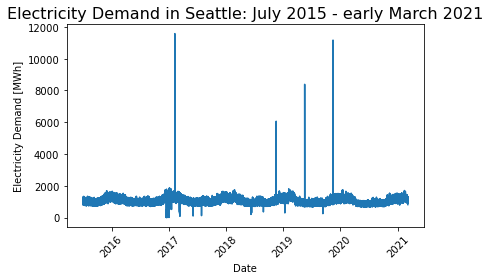

In [8]:
fig,ax = plt.subplots()
ax.plot(raw.reset_index()['DATE'], raw['DEMAND'])
ax.set_title('Electricity Demand in Seattle: July 2015 - early March 2021', fontsize=16)
ax.set_ylabel('Electricity Demand [MWh]')
ax.set_xlabel('Date')
plt.xticks(rotation = 45)
plt.tight_layout()

**Discuss specifics of handling outliers for time series: spline interpolation, manual research**

## Show after handling erroneous values

In [9]:
df = pickle.load( open( "Files and viz/seattle_data.pkl", "rb" ) )

In [10]:
df.head()

DATE   SHORTDATE  Temperature  Precipitation  Humidity  \
0 2015-07-02 00:53:00  2015-07-02         74.0            0.0      48.0   
1 2015-07-02 01:53:00  2015-07-02         72.0            0.0      53.0   
2 2015-07-02 02:53:00  2015-07-02         70.0            0.0      55.0   
3 2015-07-02 03:53:00  2015-07-02         68.0            0.0      59.0   
4 2015-07-02 04:53:00  2015-07-02         68.0            0.0      61.0   

  Condition  Pressure  Visibility WindDirection  WindSpeed  DEMAND  
0       CLR     29.94        10.0          Calm        0.0  1282.0  
1       CLR     29.94        10.0      Variable        3.0  1277.0  
2       CLR     29.95        10.0         North        3.0  1226.0  
3       CLR     29.96        10.0          Calm        0.0  1186.0  
4       CLR     29.97        10.0          West        3.0  1157.0

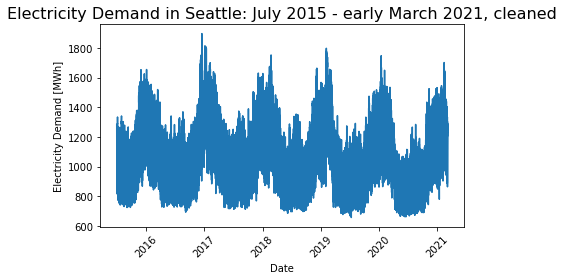

In [11]:
fig,ax = plt.subplots()
ax.plot(df['DATE'], df['DEMAND'])
ax.set_title('Electricity Demand in Seattle: July 2015 - early March 2021, cleaned', fontsize=16)
ax.set_ylabel('Electricity Demand [MWh]')
ax.set_xlabel('Date')
plt.xticks(rotation = 45)
plt.tight_layout()

**Discuss what can be determined from looking at the cleaned time series:**

## Determining Time Series components: Testing for stationarity

### ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

A function is created to carry out the ADF test on a time series.

In [12]:
def adf_test(timeseries):
    pd.set_option('display.float_format', lambda x: '%.13f' % x)
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [13]:
adf_test(df.DEMAND)

Results of Dickey-Fuller Test:
Test Statistic                   -7.9400432623136
p-value                           0.0000000000033
#Lags Used                       56.0000000000000
Number of Observations Used   47367.0000000000000
Critical Value (1%)              -3.4304880635129
Critical Value (5%)              -2.8616010211625
Critical Value (10%)             -2.5668024795597
dtype: float64


Based upon the significance level of 0.05 and the very low p-value of ADF test, the null hypothesis can be rejected. Hence, the ADF test suggests the series cannot be concluded as non-stationary. **ADF indicates Stationarity.**

### KPSS Test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

A function is created to carry out the KPSS test on a time series.

In [14]:
def kpss_test(timeseries):
    pd.set_option('display.float_format', lambda x: '%.13f' % x)
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
kpss_test(df.DEMAND)

Results of KPSS Test:
Test Statistic            1.4383146270424
p-value                   0.0100000000000
Lags Used               100.0000000000000
Critical Value (10%)      0.3470000000000
Critical Value (5%)       0.4630000000000
Critical Value (2.5%)     0.5740000000000
Critical Value (1%)       0.7390000000000
dtype: float64


/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test. **KPSS indicates non-stationarity.**

*Outcomes of the two statistical tests for stationarity: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.*

## ACF and PACF Plots

### ACF Plot

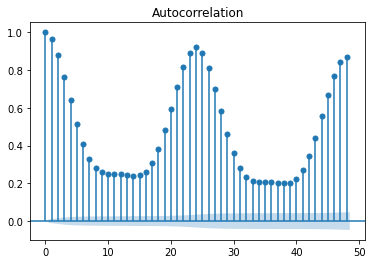

In [16]:
sm.graphics.tsa.plot_acf(df.DEMAND.values.squeeze(), lags=48)
plt.show()

**Describe findings from ACF Plot**

### PACF Plot

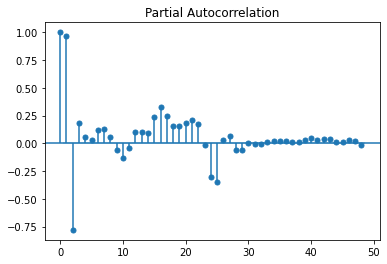

In [17]:
sm.graphics.tsa.plot_pacf(df.DEMAND.values.squeeze(), lags=48)
plt.show()

**Describe findings from PACF plot**

### Apply differencing and rerun statistical tests

In [18]:
diff_1 = df.DEMAND.diff()
diff_1 = diff_1.dropna()

#### ACF Plot with differencing of 1

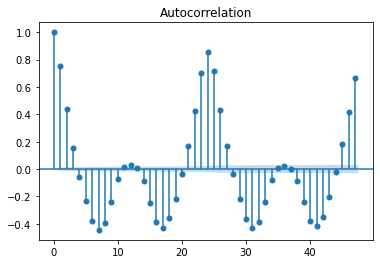

In [19]:
tsa.plot_acf(diff_1, alpha=0.05)
plt.show()

In [20]:
diff_2 = diff_1.diff()
diff_2 = diff_2.dropna()

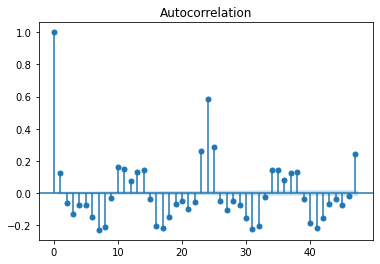

In [21]:
tsa.plot_acf(diff_2, alpha=0.05)
plt.show()

**Describe acf plot of differencing 2**

## acf plot with diff 3

In [22]:
diff_3 = diff_2.diff()
diff_3 = diff_3.dropna()

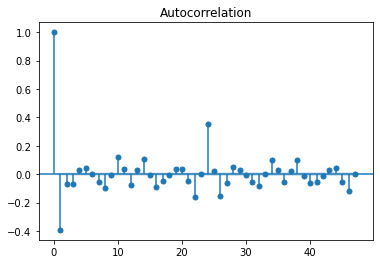

In [23]:
tsa.plot_acf(diff_3, alpha=0.05)
plt.show()

**Describe acf plot of differencing 3, and why it is too much differencing**

## Statistical Tests with Differenced Data

### With difference 1

In [24]:

def adf_test(timeseries):
    pd.set_option('display.float_format', lambda x: '%.13f' % x)
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [25]:
adf_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -38.8875285437762
p-value                           0.0000000000000
#Lags Used                       56.0000000000000
Number of Observations Used   47366.0000000000000
Critical Value (1%)              -3.4304880664279
Critical Value (5%)              -2.8616010224508
Critical Value (10%)             -2.5668024802454
dtype: float64


Based upon the significance level of 0.05 and the very low p-value of ADF test, the null hypothesis can be rejected. Hence, the ADF test suggests the series cannot be concluded as non-stationary. **ADF indicates Stationarity.**

### KPSS Test

In [26]:
def kpss_test(timeseries):
    pd.set_option('display.float_format', lambda x: '%.13f' % x)
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [27]:
kpss_test(diff_1)

Results of KPSS Test:
Test Statistic             0.0361549711339
p-value                    0.1000000000000
Lags Used               3223.0000000000000
Critical Value (10%)       0.3470000000000
Critical Value (5%)        0.4630000000000
Critical Value (2.5%)      0.5740000000000
Critical Value (1%)        0.7390000000000
dtype: float64


/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## differencing by 1 and 24

In [28]:
import statsmodels.tsa.api as smt

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickeyâ€“Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

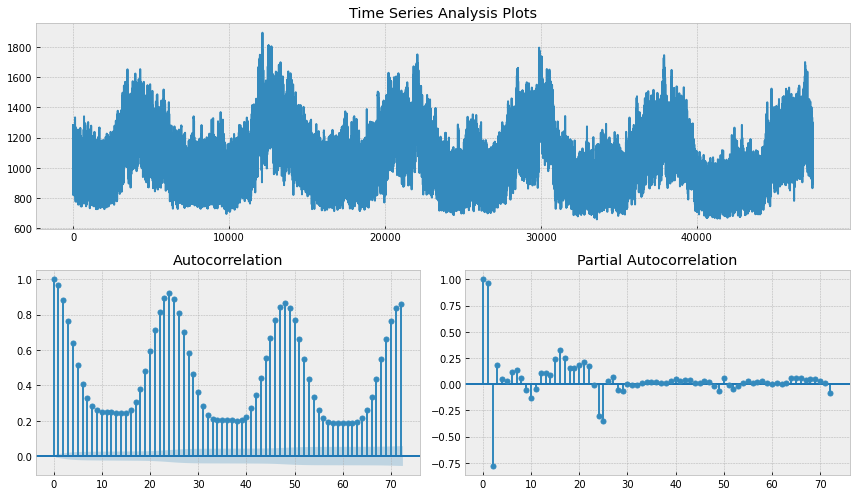

In [31]:
tsplot(df.DEMAND, lags=72)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

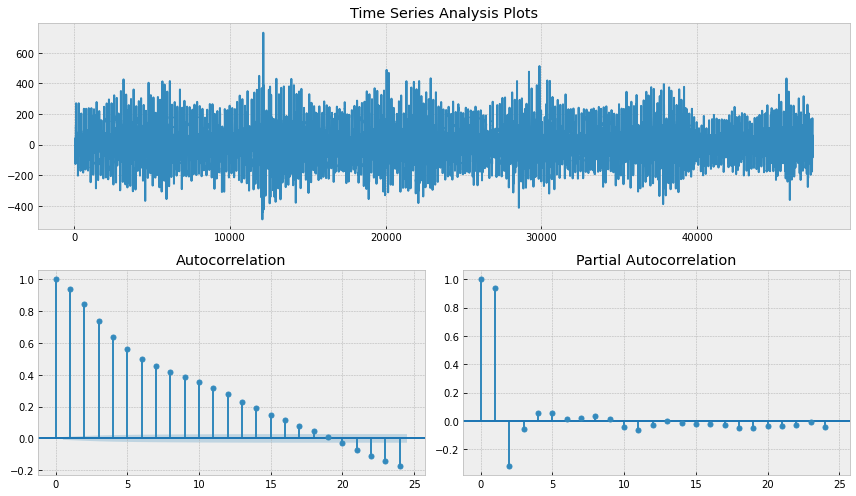

In [45]:
demand_diff = df.DEMAND - df.DEMAND.shift(24)
demand_diff = demand_diff.dropna()
tsplot(demand_diff[24:], lags=24)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

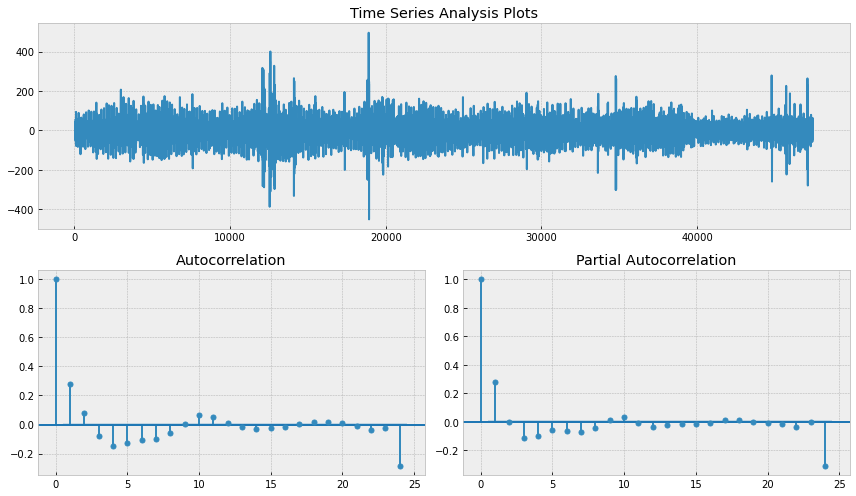

In [46]:
demand_diff = demand_diff - demand_diff.shift(1)
demand_diff = demand_diff.dropna()
tsplot(demand_diff[24+1:], lags=24)

In [47]:
kpss_test(demand_diff)

Results of KPSS Test:
Test Statistic            0.0019737717441
p-value                   0.1000000000000
Lags Used               154.0000000000000
Critical Value (10%)      0.3470000000000
Critical Value (5%)       0.4630000000000
Critical Value (2.5%)     0.5740000000000
Critical Value (1%)       0.7390000000000
dtype: float64


/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [48]:
adf_test(demand_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -52.7282806618431
p-value                           0.0000000000000
#Lags Used                       55.0000000000000
Number of Observations Used   47343.0000000000000
Critical Value (1%)              -3.4304881335065
Critical Value (5%)              -2.8616010520975
Critical Value (10%)             -2.5668024960255
dtype: float64
